In [66]:
import numpy as np
import pandas as pd
import requests
import json
from tqdm import tqdm
from bs4 import BeautifulSoup

# 0. 개요

### 영화 평점에 따른 단어 유사도의 차이가 있는지

# 1. 데이터 수집 ( 영화 리뷰 데이터)
   - 현재 상영영화 예매순 100개
   - 리뷰 100개씩

In [241]:
def getMovie(url, each, page): # each 는 크롤링할 영화의 개수를 의미, page 는 크롤링할 리뷰 페이지를 의미 (페이지당 10개))

    # 위 url 에서 노출되는 영화는 89건
    response  = requests.get(url)
    soup = BeautifulSoup(response.text, 'html.parser')
    found_items = soup.select('div.lst_wrap > ul.lst_detail_t1 > li')
    found_items = found_items[: each]
    data = []
    for item in tqdm(found_items):

        # 영화 상세 페이지 url
        movie_url = 'https://movie.naver.com' + item.select_one('dl.lst_dsc > dt.tit > a')['href']
        movie_url = movie_url.replace('basic', 'point') # 영화 상세 메인 페이지 -> 영화 상세 평점 페이지 (리뷰 개수 때문에))
        code = movie_url.split('code=')[1] # 영화 코드 추출

        # 상세 페이지로 이동
        response  = requests.get(movie_url)
        soup = BeautifulSoup(response.text, 'html.parser')

        # 영화 제목
        title = soup.select_one('div.mv_info_area > div.mv_info > h3.h_movie > a').text

        # 평점들 (관람객평점, 기자/평론가평점, 네티즌평점)
        try:
            a_score = soup.select_one('div.mv_info_area > div.mv_info > div.main_score > div.score > a > div > span').text
            a_score = a_score.split('점')[1]
            if a_score == ' 없음':
                a_score = 'none'
        except:
            a_score = 'none'

        try:
            r_score = soup.select_one('div.mv_info_area > div.mv_info > div.main_score > div.score:nth-child(2) > div.spc_score_area > a > div > span > span')['style'] # 평점이 별점 css의 넓이로도 표현됨
            r_score = int(r_score.split(':')[1].split('%')[0].replace('.', '')) / 100 # 넓이를 int로 변환 후 평점으로 변경
        except:
            r_score = 'none'
            
        try:
            n_score = soup.select_one('div.mv_info_area > div.mv_info > div.main_score > div.score_left > div.star_score > a > span > span')['style']
            n_score = int(n_score.split(':')[1].split('%')[0].replace('.', '')) / 100
        except:
            r_score = 'none'
            
        # 관람객 리뷰
        review_list = []
        for i in range(1,page): # page는 크롤링할 리뷰페이지를 의미,( 1page x 10 )
            # {code} 는 위에서 크롤링한 영화 고유의 code를 의미함
            #reviews_url 은 리뷰데이터를 따로 보관하고 있는 페이지임
            reviews_url = f'https://movie.naver.com/movie/bi/mi/pointWriteFormList.nhn?code={code}&type=after&isActualPointWriteExecute=false&isMileageSubscriptionAlready=false&isMileageSubscriptionReject=false&page={i}'
            response = requests.get(reviews_url)
            soup = BeautifulSoup(response.text, 'html.parser')
            reviews = soup.select('div.score_result > ul > li')
            for review in reviews:
#                 score = review.select_one('div.star_score > em').text
                content = review.select_one('div.score_reple > p').text.strip()
                if '관람객' in content[:5]:
                    content = content[4:].strip()

                value = content
                review_list.append(value)
#         print([title], '크롤링 완료')
        value = [title, a_score, r_score, n_score, review_list]
        data.append(value)
    return data

In [242]:
url = 'https://movie.naver.com/movie/running/current.nhn'
data = getMovie(url, 100, 20)

100%|██████████| 100/100 [03:09<00:00,  1.89s/it]


In [243]:
# 저장
df = pd.DataFrame(data, columns = ['영화제목', '관람객평점', '기자/평론가평점', '네티즌평점', '리뷰'])
df.to_excel('./영화리뷰.xlsx')

In [246]:
# 불러오기
df = pd.read_excel('./영화리뷰.xlsx')
df = df.drop('Unnamed: 0', axis = 1)

# 2. 데이터 전처리

In [247]:
df.head(3)

,영화제목,관람객평점,기자/평론가평점,네티즌평점,리뷰
0,인비저블맨,9.03,none,7.94,"['옆에서 기침을 시작하자 비로소 공포영화임을 느꼈다.', '영화관에 나혼자 있는게..."
1,1917,9.11,none,8.94,['이 영화는 미쳤다. 넷플릭스가 일상화된 시대에 극장이 존재해야하는 이유를 증명해...
2,다크 워터스,9.08,none,8.56,"['영화관에 나 혼자만 있다는 현실이 더 무섭다', '엄기영 앵커 보신분들은 공감..."


In [248]:
# 인덱스 80 삭제 (평점, 리뷰 없음)
df = df.drop(80)

In [249]:
df = df.reset_index()

In [250]:
# 관람객평점 네티즌평점 평균
scores = []
for i in range(len(df)):
    ascore = df['관람객평점'].loc[i]
    nscore = df['네티즌평점'].loc[i]
    try:
        score = (ascore * nscore) / 2
    except:
        score = nscore
    scores.append(score)

In [251]:
df['score'] = scores

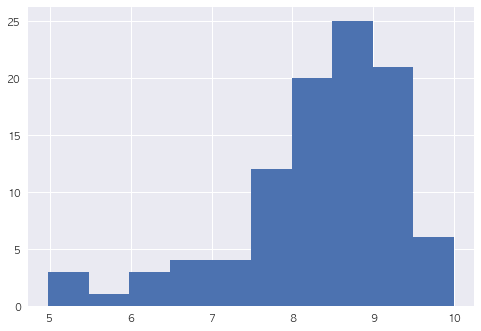

In [252]:
# 평균 평점 분포도
df['score'].hist()

In [253]:
df.head()

,index,영화제목,관람객평점,기자/평론가평점,네티즌평점,리뷰,score
0,0,인비저블맨,9.03,none,7.94,"['옆에서 기침을 시작하자 비로소 공포영화임을 느꼈다.', '영화관에 나혼자 있는게...",7.94
1,1,1917,9.11,none,8.94,['이 영화는 미쳤다. 넷플릭스가 일상화된 시대에 극장이 존재해야하는 이유를 증명해...,8.94
2,2,다크 워터스,9.08,none,8.56,"['영화관에 나 혼자만 있다는 현실이 더 무섭다', '엄기영 앵커 보신분들은 공감...",8.56
3,3,지푸라기라도 잡고 싶은 짐승들,8.10,none,6.56,['아니 개봉당일날 9시 땡하고 부터 평점 쏟아지는게 말이 돼냐? 요즘 조조는 꼭두...,6.56
4,4,작은 아씨들,9.15,none,8.83,['왜 여성은 사랑을 해야하냐며 말하면서도 사랑을 받고 싶다고 외치던 장면이 너무나...,8.83


In [256]:
# 리뷰에 블러 처리 되어있는 곳에서 \\n\\t\\r 표시가 나타남 -> 삭제
df['리뷰'] = df['리뷰'].apply(lambda x : x.replace('\\n','').replace('\\r','').replace('\\t',''))

In [257]:
# 평점 평균 9점을 기준으로 구분
high = df.loc[df['score'] >= 9]
row = df.loc[df['score'] < 9]

In [258]:
high = high.reset_index()
row = row.reset_index()

# 3. Tokeninzing

In [259]:
twitter = Okt()  #twitter class 객체당!
komoran = Komoran()
kkma = Kkma()
# mecab = Mecab()
# hannanum = Hannanum()

In [260]:
df['리뷰'][0]

'[\'옆에서 기침을 시작하자 비로소 공포영화임을 느꼈다.\', \'영화관에 나혼자 있는게 제일 무서웠다\', \'우한코로나 때문에 관객이 인비저블...\', \'진짜 무섭거나 잔인한 장면 없이 공포감을 불러일으킴.간만에 진짜 재밌게 본 스릴러 영화.\', \'재밌으면 추천 재미없음 비추천 이것좀 그만 하면 안되나? 그런 사람들 프로필 드가봐요 다 그런 댓글만 있음 영화를 더럽히는 댓글들임\', \'스포일러가 포함된 감상평입니다. 감상평 보기한국이었으면 센서등에 걸릴 놈이 미국이라 운좋았다\', \'스포일러가 포함된 감상평입니다. 감상평 보기가장 놀란 부분 : 개밥그릇 발로 찼을 때\', \'음향이랑 카메라칵도에 4점 배우 연기 4점 흑인경찰친구 근육5점 스토리 3점 결말 3점\', \'세실리아가 부릅니다, ‘Show Yourself’~!\', \'환공포증 걸릴뻔했네....\', \'지금 봐라 코로나 때문에 극장에서 혼자 봄\', \'강아지 죽을까봐 보는내내 불안했음 마지막에 편---안\', \'귀신나오고 말도안되는거 싫어하는데 이건 스토킹과 현대과학이 섞여 현실감있었다.. 결론도 사이다에 스토리전개도 빠르고 자극적이고 이시국에 영화관간게 안아까웠다\', \'미쳤다 그냥..개꿀잼이에요우리나라 흔해빠진 공포영화라는 차원이다름;보고 배우세요 제발\', \'투명인간보다 더 무서운 여주인공\', \'이거 보고왔는데 눈치 없는 울집 강아지 허공에 대고 짖길래ㅜㅜ 벌벌 떨면서 담요 던져봄ㅜㅜㅜㅜ 진짜 무서워 죽을뻔\', \'여주 표정연기 미쳤다 내가 더 몰입되\', \'업그레이드 감독이라 스프라이즈, 음향효과에도 스프라이즈\', \'무섭게 재밌다 추천 아니다 비추천\', \'별로 기대안했는데 진짜 재밌었어요 처음부터 끝까지 계속 긴장감있고 흥미진진해요 보면서 계속 이 사람이 말하는게 근데 사실인가 아님 저게 사실인가 의심이 드는 영화이기도 하고요 추천합니다!\', \'영화 끝나는 순간 내 주위에 누군가 있음을 자각하게 된다.\', \'스포일러가 포함된 감상평입니다. 감상

In [261]:
# puctuation(구두점?)은 필요없는 데이터로 생각됨
# josa도 필요없을 것으로 예상됨
twitter.pos(df['리뷰'][0])[:30]

[("['", 'Punctuation'),
 ('옆', 'Noun'),
 ('에서', 'Josa'),
 ('기침', 'Noun'),
 ('을', 'Josa'),
 ('시작', 'Noun'),
 ('하자', 'Verb'),
 ('비로소', 'Noun'),
 ('공포영화', 'Noun'),
 ('임', 'Noun'),
 ('을', 'Josa'),
 ('느꼈다', 'Verb'),
 (".',", 'Punctuation'),
 ("'", 'Punctuation'),
 ('영화관', 'Noun'),
 ('에', 'Josa'),
 ('나', 'Noun'),
 ('혼자', 'Noun'),
 ('있는게', 'Adjective'),
 ('제일', 'Noun'),
 ('무서웠다', 'Adjective'),
 ("',", 'Punctuation'),
 ("'", 'Punctuation'),
 ('우한', 'Noun'),
 ('코로나', 'Noun'),
 ('때문', 'Noun'),
 ('에', 'Josa'),
 ('관객', 'Noun'),
 ('이', 'Josa'),
 ('인비저블', 'Noun')]

In [262]:
def tokenize(df):
    corpus = []
    for text in df['리뷰']:
        corpus.append(['/'.join(p) for p in twitter.pos(text) if p[1] != "Josa" and p[1] != "Punctuation"])
    return corpus

In [263]:
corpus_high = tokenize(high)

In [264]:
corpus_row = tokenize(row)

In [265]:
corpus_high[0][:30]

['앨리/Noun',
 '잭슨/Noun',
 '사랑/Noun',
 '잭슨/Noun',
 '앨리/Noun',
 '세상/Noun',
 '선물/Noun',
 '했다/Verb',
 '연기/Noun',
 '연출/Noun',
 '음악/Noun',
 '하나/Noun',
 '빠지는게/Verb',
 '없다/Adjective',
 '올해/Noun',
 '본/Verb',
 '최고/Noun',
 '음악/Noun',
 '영화/Noun',
 '인생/Noun',
 '어떤/Adjective',
 '사람/Noun',
 '만나는지에/Verb',
 '따라/Verb',
 '인생/Noun',
 '바뀔/Verb',
 '수/Noun',
 '있다/Adjective',
 '형/Noun',
 '후진/Noun']

###  3-1. 시각화

잘 나오는 것 같지는 않다.. 쓸데없는 단어가 너무 많은 듯

In [283]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn')
plt.rc('font', family = 'AppleGothic')
plt.rc('axes', unicode_minus = False)

In [267]:
high_text = []
row_text = []
for data in corpus_high:
    high_text.extend(data)
    
for data in corpus_row:
    row_text.extend(data)

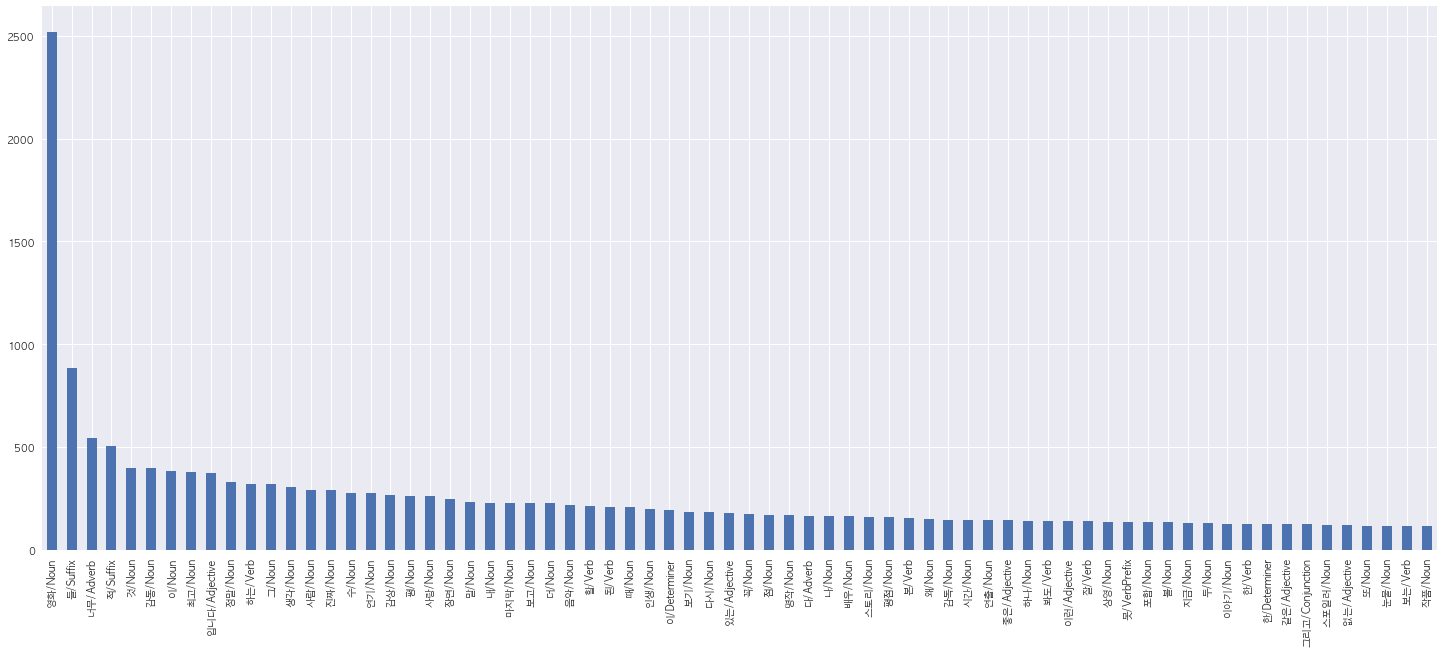

In [268]:
pd.DataFrame(high_text)[0].value_counts()[0:70].plot(kind='bar', figsize=(25,10))

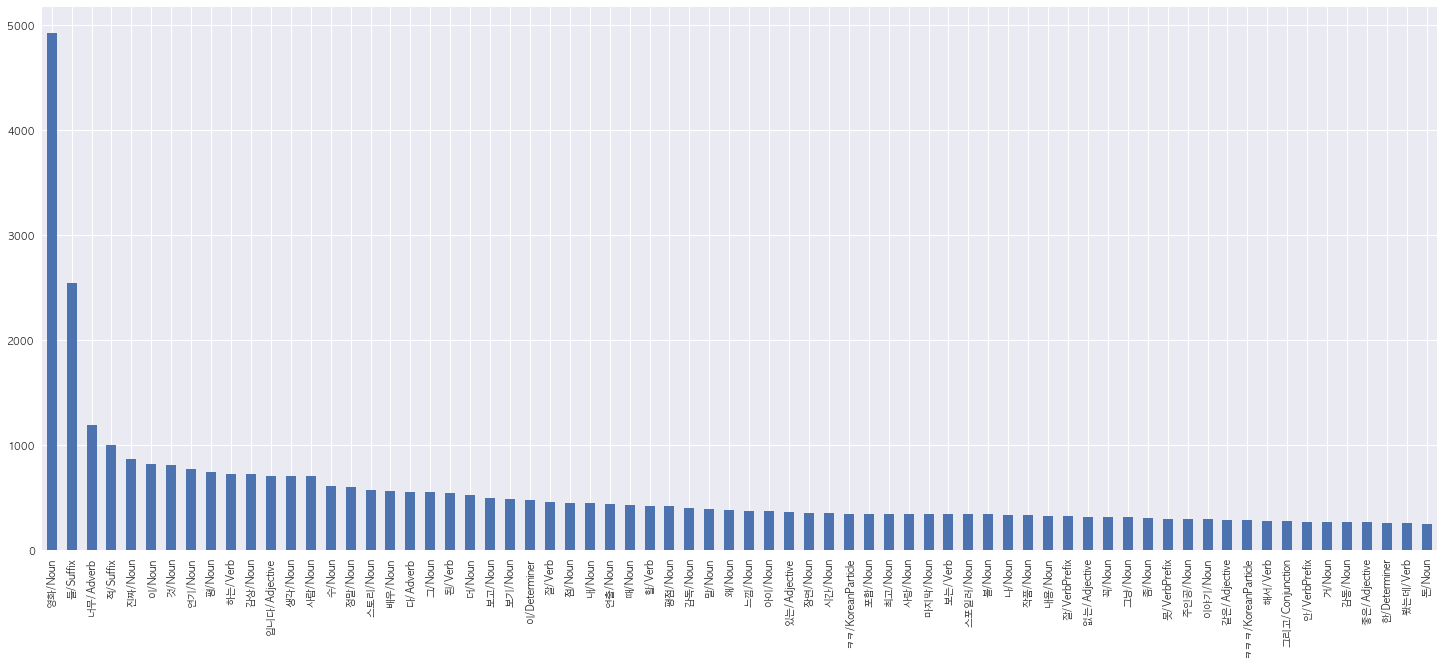

In [269]:
pd.DataFrame(row_text)[0].value_counts()[0:70].plot(kind='bar', figsize=(25,10))

# 4. Embeding

### 4-1. word2vec

In [307]:
from gensim.models import Word2Vec, FastText

In [271]:
Skip_Gram_model = Word2Vec(corpus_high, size=2, window=3, min_count=1, workers=1, iter=1000, sg=1)
Skip_Gram_model2 = Word2Vec(corpus_row, size=2, window=3, min_count=1, workers=1, iter=1000, sg=1)

In [272]:
#index2word
words = Skip_Gram_model.wv.index2word #one-hot encoding알아서 해줌 
words2 = Skip_Gram_model2.wv.index2word
print(words[:5])
print(words2[:5])

['영화/Noun', '들/Suffix', '너무/Adverb', '적/Suffix', '것/Noun']
['영화/Noun', '들/Suffix', '너무/Adverb', '적/Suffix', '진짜/Noun']


In [273]:
# text 토큰 임베딩 벡터
vectors = Skip_Gram_model.wv.vectors
vectors2 = Skip_Gram_model2.wv.vectors
print(vectors[:5],'\n\n',vectors2[:5])

[[-0.57597435 -0.9570121 ]
 [-1.0242858  -0.34946814]
 [-0.39971384 -1.2093611 ]
 [-0.73513603 -0.6166669 ]
 [-0.98817205 -0.38942692]] 

 [[-0.9235952   0.4289315 ]
 [-0.90568876  0.41304344]
 [-1.1410775  -0.22609034]
 [-0.9674465   0.26251096]
 [-1.1372007  -0.15212879]]


In [274]:
# 토큰과 벡터 zip
Skip_Gram_model_result = dict(zip(words, vectors))

In [291]:
# 유사도 top5
print(Skip_Gram_model.most_similar('감동/Noun', topn=5)) 
print(Skip_Gram_model2.most_similar('감동/Noun', topn=5))

[('잔잔하게만/Adjective', 0.9999999403953552), ('한없이/Adverb', 0.9999998807907104), ('였음/Verb', 0.9999998807907104), ('어쨋/Noun', 0.9999998807907104), ('재구/Verb', 0.9999997615814209)]
[('브레핏/Noun', 1.0), ('ㄱㅌㅋㄲ/KoreanParticle', 1.0), ('재수없을거/Adjective', 1.0), ('중독/Noun', 1.0), ('이었다니/Verb', 0.9999999403953552)]


In [294]:
print(Skip_Gram_model.most_similar('지루/Noun', topn=5)) 
print(Skip_Gram_model2.most_similar('지루/Noun', topn=5))

[('쳐다보지도/Verb', 1.0), ('번영/Noun', 1.0), ('긴줄도/Verb', 1.0), ('그런지는/Adjective', 1.0), ('ㅉ/KoreanParticle', 1.0)]
[('재미있었지만/Adjective', 1.0000001192092896), ('엽집꼬마존윅/Noun', 1.0), ('맛깔나게/Adjective', 1.0), ('물들의/Verb', 1.0), ('망설인/Verb', 1.0)]


In [293]:
print(Skip_Gram_model.most_similar('쓰레기/Noun', topn=5)) 
print(Skip_Gram_model2.most_similar('쓰레기/Noun', topn=5))

[('뺑반/Noun', 1.0), ('깎는다/Verb', 1.0), ('맨/Modifier', 1.0), ('긴장감/Noun', 1.0), ('특별한것은/Adjective', 0.9999999403953552)]
[('지독한/Adjective', 1.0), ('탁/Noun', 1.0), ('좋/Noun', 1.0), ('가까이/Noun', 1.0), ('끌어당기는/Verb', 1.0)]


In [278]:
w2v_df = pd.DataFrame(vectors, columns = ['x1', 'x2'])
w2v_df['word'] = words
w2v_df = w2v_df[['word', 'x1', 'x2']]
w2v_df

,word,x1,x2
0,영화/Noun,-0.575974,-0.957012
1,들/Suffix,-1.024286,-0.349468
2,너무/Adverb,-0.399714,-1.209361
3,적/Suffix,-0.735136,-0.616667
4,것/Noun,-0.988172,-0.389427
...,...,...,...
13054,몰랐다며/Verb,-0.583944,-1.176857
13055,가처분/Noun,-0.034834,-2.673667
13056,팟캐스트/Noun,-1.247645,-0.130152
13057,듣/Verb,-1.277281,-0.093318


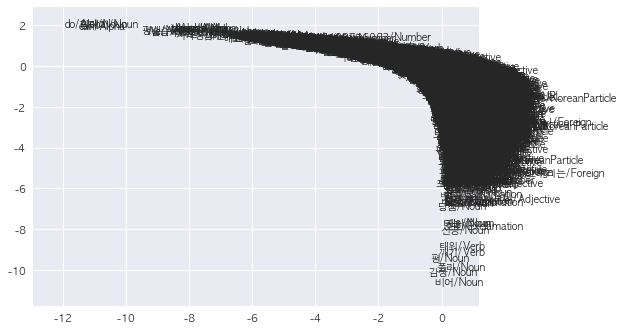

In [284]:
import matplotlib.pyplot as plt
import numpy as np
warnings.filterwarnings("ignore", category=DeprecationWarning) 

fig, ax = plt.subplots()

for word, x1, x2 in zip(w2v_df['word'], w2v_df['x1'], w2v_df['x2']):
    ax.annotate(word, (x1,x2 ))
    
PADDING = 1.0
x_axis_min = np.amin(vectors, axis=0)[0] - PADDING
y_axis_min = np.amin(vectors, axis=0)[1] - PADDING
x_axis_max = np.amax(vectors, axis=0)[0] + PADDING
y_axis_max = np.amax(vectors, axis=0)[1] + PADDING
 
plt.xlim(x_axis_min,x_axis_max)
plt.ylim(y_axis_min,y_axis_max)
plt.rcParams["figure.figsize"] = (10,10)

plt.show()

### 4-2. FastText

In [308]:
Skip_Gram_model3 = FastText(corpus_high, size=10, window=3, min_count=3, workers=1, iter=1000, sg=1)

In [317]:
Skip_Gram_model4 = FastText(corpus_row, size=10, window=3, min_count=3, workers=1, iter=1000, sg=1)

In [318]:
#index2word
words = Skip_Gram_model3.wv.index2word
words2 = Skip_Gram_model4.wv.index2word
print(words[:5])
print(words2[:5])

['영화/Noun', '들/Suffix', '너무/Adverb', '적/Suffix', '것/Noun']
['영화/Noun', '들/Suffix', '너무/Adverb', '적/Suffix', '진짜/Noun']


In [319]:
vectors = Skip_Gram_model3.wv.vectors
vectors2 = Skip_Gram_model4.wv.vectors
print(vectors[:5],'\n\n',vectors2[:5])

[[-0.28140795 -0.22632611  0.24951929  0.5556262  -0.08301441  0.30546194
  -0.21991087  0.10664916 -0.42990428  0.05914424]
 [ 0.15130994 -0.0622793   0.34591767  0.18203405 -0.43823898  0.26520965
  -0.800092   -0.0634257  -0.26475665 -0.23431912]
 [-0.09329364 -0.49825498 -0.17583998  0.4199265  -0.2099813   0.0845623
  -0.2522218  -0.4114281  -0.5770619   0.105877  ]
 [ 0.07313786 -0.4889976   0.41710487  0.11549505 -0.41401058 -0.02049782
  -0.3625828  -0.01536921 -0.8676769  -0.6227588 ]
 [-0.36244518  0.22340581  0.36476335  0.22195423 -0.50668967  0.27726954
  -0.49072045  0.18943527 -0.24955197 -0.24525575]] 

 [[-0.12285627 -0.39373854 -0.40903357  0.67555577  0.20049407 -0.09224203
  -0.03599266  0.09492757 -0.34273246  0.11149801]
 [ 0.00328706 -0.18932141 -0.3016353   0.5632625   0.03740828 -0.54176486
   0.19134998 -0.24217653 -0.17384788  0.04188104]
 [ 0.14616644 -0.3727458   0.07815107  0.9521812  -0.22170453 -0.0926572
  -0.29925144  0.02930958  0.05198776 -0.00280699

In [320]:
# 유사도 top5
print(Skip_Gram_model3.most_similar('감동/Noun', topn=5)) 
print(Skip_Gram_model4.most_similar('감동/Noun', topn=5))

[('좋습니다/Adjective', 0.9561736583709717), ('울림/Noun', 0.9277921915054321), ('보는내내/Verb', 0.9232908487319946), ('웃음/Noun', 0.9101909399032593), ('봐야겠어요/Verb', 0.9034826755523682)]
[('조연/Noun', 0.9739319086074829), ('듣기/Noun', 0.9473122954368591), ('호흡/Noun', 0.9460064172744751), ('였던것/Verb', 0.9444116353988647), ('듦/Verb', 0.9434994459152222)]


In [321]:
print(Skip_Gram_model3.most_similar('재미/Noun', topn=5)) 
print(Skip_Gram_model4.most_similar('재미/Noun', topn=5))

[('정석/Noun', 0.9309725165367126), ('러브액츄얼리/Noun', 0.8981155157089233), ('높네요/Adjective', 0.8848985433578491), ('개인/Noun', 0.8846042156219482), ('고/Modifier', 0.8809015154838562)]
[('반전/Noun', 0.9776228070259094), ('심플/Noun', 0.9718899130821228), ('초반/Noun', 0.9675329327583313), ('조금/Noun', 0.9636390209197998), ('약간/Noun', 0.9508594870567322)]


In [325]:
print(Skip_Gram_model3.most_similar('미쳤다/Verb', topn=5)) 
print(Skip_Gram_model4.most_similar('미쳤다/Verb', topn=5))

[('걸작/Noun', 0.9357905387878418), ('좋았는데/Adjective', 0.9334442019462585), ('지리/Noun', 0.9270041584968567), ('만/Modifier', 0.9242832064628601), ('이후/Noun', 0.9161233901977539)]
[('첫/Modifier', 0.9319682121276855), ('그런데/Conjunction', 0.9147347211837769), ('드는데/Verb', 0.9107687473297119), ('이런게/Adjective', 0.9078778624534607), ('좋았을텐데/Adjective', 0.9028246998786926)]


In [358]:
print(Skip_Gram_model3.most_similar('연기/Noun', topn=5)) 
print(Skip_Gram_model4.most_similar('연기/Noun', topn=5))

[('배우/Noun', 0.9814444184303284), ('외모/Noun', 0.9607532024383545), ('연기력/Noun', 0.9584969878196716), ('코믹/Noun', 0.9564279913902283), ('일품/Noun', 0.954630434513092)]
[('나름/Noun', 0.9700016975402832), ('작화/Noun', 0.9675467610359192), ('굿/Noun', 0.9541835188865662), ('미도/Noun', 0.9503493905067444), ('강해서/Adjective', 0.9478863477706909)]


# 5. 후기 

#### (1) 주의사항 2번에서 요구된 결과가 가장 좋은 모델은 선택하는 것에 대한 이해가 부족했던 것 같다. step4 임베딩 이후에 어떤 모델이 더 성능이 좋은지 어떻게 판단해야하는지 모르겠다.. 단순 단어 유사도로 보게된다면 word2vec보다는 fasttext가 보다 유사한 단어를 잘 찾은 것 같았다.

#### (2) 아쉬웠던 부분은 tockenizing을 하기 전에 텍스트 전처리를 더욱 해야할 것 같은 생각이 들었다. 의미없는 단어가 너무 많은 것 같다고 느꼈다.

#### (3) 또한 평점에 따른 단어 분포도 및 유사도를 알고 싶었는데 단순 평점 9점을 기준으로 영화를 구분하는 것보다 9점 이상대와 5점 이하 영화만을 따로 진행했으면 좋았을 듯 싶다. 간단히 빠르게 해봐야겠다.

#### (4) 단어 임베딩을 통한 단어의 벡터화에 대한 이해도가 부족하다보니 어떤식으로 활용해야할지 감이 잡히지 않았다..주르규ㅠ

# 6. 이 외

In [329]:
df.head()

,index,영화제목,관람객평점,기자/평론가평점,네티즌평점,리뷰,score
0,0,인비저블맨,9.03,none,7.94,"['옆에서 기침을 시작하자 비로소 공포영화임을 느꼈다.', '영화관에 나혼자 있는게...",7.94
1,1,1917,9.11,none,8.94,['이 영화는 미쳤다. 넷플릭스가 일상화된 시대에 극장이 존재해야하는 이유를 증명해...,8.94
2,2,다크 워터스,9.08,none,8.56,"['영화관에 나 혼자만 있다는 현실이 더 무섭다', '엄기영 앵커 보신분들은 공감...",8.56
3,3,지푸라기라도 잡고 싶은 짐승들,8.10,none,6.56,['아니 개봉당일날 9시 땡하고 부터 평점 쏟아지는게 말이 돼냐? 요즘 조조는 꼭두...,6.56
4,4,작은 아씨들,9.15,none,8.83,['왜 여성은 사랑을 해야하냐며 말하면서도 사랑을 받고 싶다고 외치던 장면이 너무나...,8.83


In [336]:
len(df.loc[df['score'] >= 9]), len(df.loc[df['score'] <= 7.5])

(27, 16)

In [337]:
# 평점 평균 9점 이상, 7.5 이하 (5점 이하가 너무 없음 ㅠ)
high = df.loc[df['score'] >= 9]
row = df.loc[df['score'] < 7.5]

In [338]:
high = high.reset_index()
row = row.reset_index()

In [339]:
corpus_high = tokenize(high)
corpus_row =  tokenize(row)

In [340]:
high_text = []
row_text = []
for data in corpus_high:
    high_text.extend(data)
    
for data in corpus_row:
    row_text.extend(data)

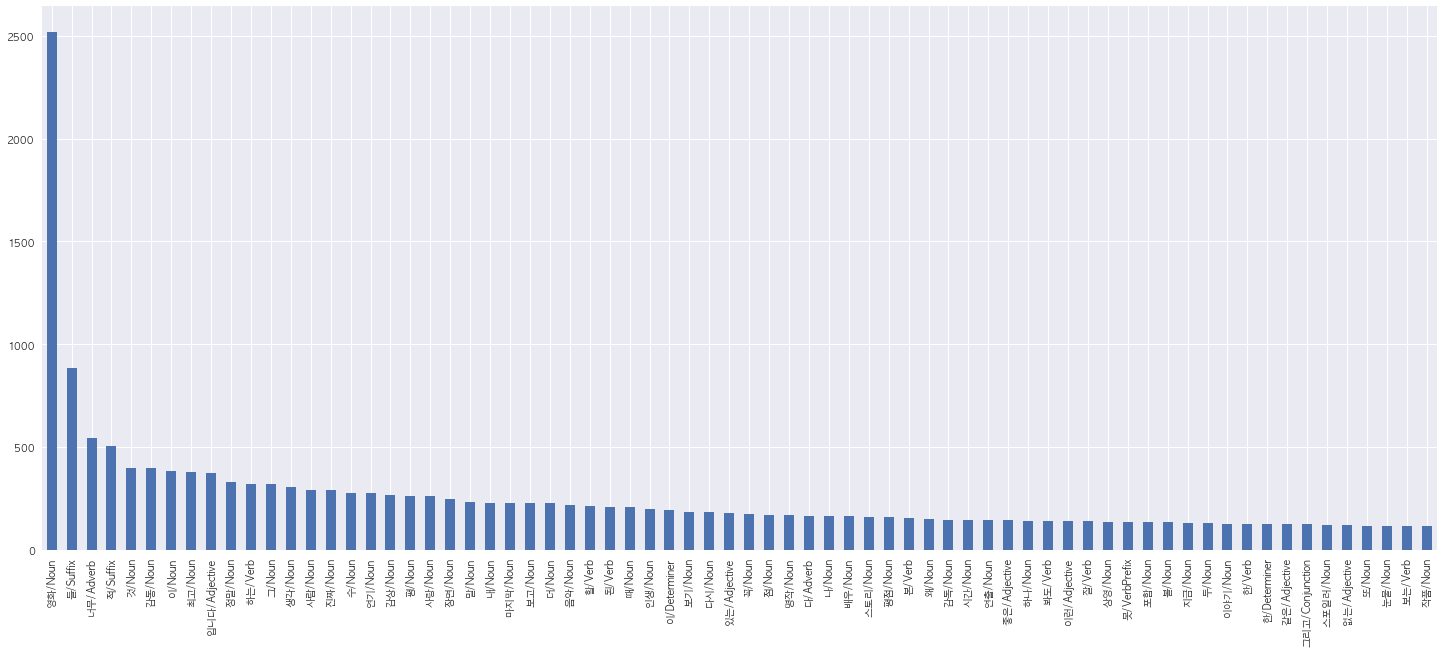

In [341]:
pd.DataFrame(high_text)[0].value_counts()[0:70].plot(kind='bar', figsize=(25,10))

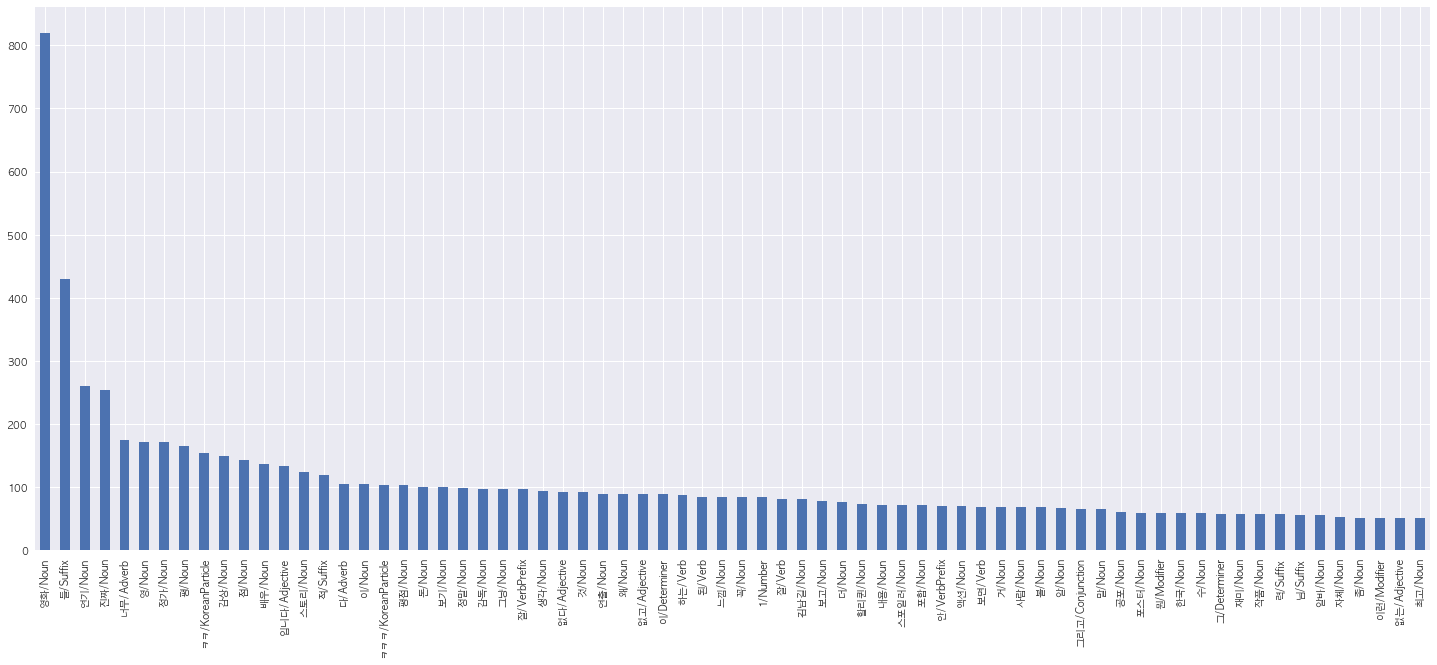

In [342]:
pd.DataFrame(row_text)[0].value_counts()[0:70].plot(kind='bar', figsize=(25,10))

In [343]:
Skip_Gram_model5 = FastText(corpus_high, size=5, window=3, min_count=3, workers=1, iter=1000, sg=1)
Skip_Gram_model6 = FastText(corpus_row, size=5, window=3, min_count=3, workers=1, iter=1000, sg=1)

In [346]:
words = Skip_Gram_model5.wv.index2word
words2 = Skip_Gram_model6.wv.index2word
print(words[:5])
print(words2[:5])

['영화/Noun', '들/Suffix', '너무/Adverb', '적/Suffix', '것/Noun']
['영화/Noun', '들/Suffix', '연기/Noun', '진짜/Noun', '너무/Adverb']


In [347]:
vectors = Skip_Gram_model5.wv.vectors
vectors2 = Skip_Gram_model6.wv.vectors
print(vectors[:5],'\n\n',vectors2[:5])

[[ 0.675877   -0.5450982  -0.01425442 -0.5915392   0.12821434]
 [ 0.25960118 -0.23254836 -0.50267935 -0.9175809  -0.17660825]
 [ 0.3400375   0.28650764  0.01422683 -0.799398    0.47153544]
 [ 0.15421164 -0.28665373 -0.92074037 -0.9504261   0.1678954 ]
 [ 0.3529358  -0.6761184  -0.1961524  -0.730549   -0.28717333]] 

 [[-0.17154779 -0.62456214  0.04095548  0.29000697 -0.3076648 ]
 [ 0.39557993 -0.3881553  -0.3546812   0.56507975  0.02519104]
 [-0.11814419 -0.6126334  -0.40426236  1.4950005   0.28809342]
 [ 0.33429554 -0.25397027 -0.14750494  0.93326426  0.18099041]
 [ 0.6557389   0.02235017  0.5072905   0.9008949  -0.2958136 ]]


In [348]:
# 유사도 top5
print(Skip_Gram_model5.most_similar('감동/Noun', topn=5)) 
print(Skip_Gram_model6.most_similar('감동/Noun', topn=5))

[('기분/Noun', 0.9966759085655212), ('거리/Noun', 0.9942765235900879), ('예상/Noun', 0.9919084310531616), ('밤/Noun', 0.9918363690376282), ('흐름/Noun', 0.9911184310913086)]
[('가장/Noun', 0.9912508726119995), ('않을까/Verb', 0.9852291345596313), ('이딴/Modifier', 0.9830439686775208), ('화가/Noun', 0.9774845838546753), ('마냥/Noun', 0.9748655557632446)]


In [349]:
print(Skip_Gram_model5.most_similar('재미/Noun', topn=5)) 
print(Skip_Gram_model6.most_similar('재미/Noun', topn=5))

[('영/Modifier', 0.9929746985435486), ('이남/Noun', 0.9929675459861755), ('떡밥/Noun', 0.9904717803001404), ('시체/Noun', 0.9903547763824463), ('가족영화/Noun', 0.9869956970214844)]
[('했던/Verb', 0.9924741983413696), ('재미없다/Adjective', 0.9910155534744263), ('선사/Noun', 0.9860429167747498), ('거짓말/Noun', 0.9832602739334106), ('해준다/Verb', 0.9793744087219238)]


In [350]:
print(Skip_Gram_model5.most_similar('연기/Noun', topn=5)) 
print(Skip_Gram_model6.most_similar('연기/Noun', topn=5))

[('울리는/Verb', 0.9986404180526733), ('심지어/Noun', 0.9966614842414856), ('아이/Noun', 0.9946432113647461), ('감명/Noun', 0.9938335418701172), ('일품/Noun', 0.9935240149497986)]
[('생각나는/Verb', 0.9931859970092773), ('보는거/Verb', 0.9882508516311646), ('듯/Noun', 0.9872702360153198), ('와중/Noun', 0.9769308567047119), ('이희준/Noun', 0.9762797951698303)]


In [360]:
print(Skip_Gram_model5.most_similar('미친/Adjective', topn=5)) 
print(Skip_Gram_model6.most_similar('미친/Adjective', topn=5))

[('꽉/Noun', 0.9917407631874084), ('볼수있어/Verb', 0.9906346797943115), ('소음/Noun', 0.9886588454246521), ('놀랐다/Verb', 0.9843302965164185), ('나오는/Verb', 0.9821693897247314)]
[('젭알/Noun', 0.9855282306671143), ('발암/Noun', 0.9834641218185425), ('만나지마라/Verb', 0.9767615795135498), ('영화감독/Noun', 0.9715625047683716), ('놈/Noun', 0.9712085127830505)]


In [363]:
print(Skip_Gram_model5.most_similar('정말/Noun', topn=5)) 
print(Skip_Gram_model6.most_similar('정말/Noun', topn=5))

[('온/Noun', 0.9955002069473267), ('옷/Noun', 0.9922602772712708), ('런던/Noun', 0.9905256032943726), ('영화/Noun', 0.9897245168685913), ('때문/Noun', 0.9896593689918518)]
[('재밌었습니다/Adjective', 0.9994509816169739), ('합니다/Verb', 0.9971396327018738), ('명작/Noun', 0.9911297559738159), ('있고/Adjective', 0.9815617799758911), ('호러영화/Noun', 0.981336236000061)]


'감동' 에 대한 단어 유사도에서는 평점 9점과 7.5이하의 영화가 어느정도 차이가 있음을 볼 수 있었다. 하지만 앞서 언급했듯이, 영화평점에서 9점과 7.5점은 큰 차이를 나타낸다고 보기 애매해서 나중에는 정말 6점대 혹은 5점대 이하를 구분해서 하면 좋을 듯 싶다. 또한 토큰화를 하기전에 데이터를 좀더 정제하면 보다 좋은 결과가 나오지 않을까 싶다.